<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Manual-Object-Identification" data-toc-modified-id="Manual-Object-Identification-1">Manual Object Identification</a></span></li><li><span><a href="#Cosmic-Ray-Rejection" data-toc-modified-id="Cosmic-Ray-Rejection-2">Cosmic Ray Rejection</a></span></li><li><span><a href="#Source-Extraction" data-toc-modified-id="Source-Extraction-3">Source Extraction</a></span></li><li><span><a href="#Annuli-Regions" data-toc-modified-id="Annuli-Regions-4">Annuli Regions</a></span><ul class="toc-item"><li><span><a href="#Region-Sizes" data-toc-modified-id="Region-Sizes-4.1">Region Sizes</a></span></li></ul></li><li><span><a href="#Extract-PCMDs" data-toc-modified-id="Extract-PCMDs-5">Extract PCMDs</a></span></li><li><span><a href="#Sky-Background" data-toc-modified-id="Sky-Background-6">Sky Background</a></span></li></ul></div>

In [1]:
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
from astropy.io import fits
from tqdm import tqdm
import pandas as pd
from astropy.wcs import WCS
import pcmdpy as ppy
import sep
import pyregion
%matplotlib inline

GPU acceleration not available, sorry
No module named 'pycuda'


In [2]:
mpl.rcParams['image.origin'] = 'lower'

In [3]:
plt.style.use('seaborn-poster')

In [4]:
# for filt in ['f475w', 'f850lp']:
#     for exp in [1, 2]:
#         hdulist = fits.open('../data/m49/raw/m49_exp{:d}_{:s}_flc.fits'.format(exp, filt))
#         h1 = hdulist[0:4]
#         h1.writeto('../data/m49/raw/m49_chip{:d}_exp{:d}_{:s}_flc.fits'.format(h1['SCI'].header['CCDCHIP'], exp, filt),
#                   overwrite=True)
#         h2 = fits.HDUList(hdus=[hdulist[0]]+list(hdulist[4:7]))
#         for hdu in h2:
#             hdu.header['EXTVER'] = 1
#         h2.writeto('../data/m49/raw/m49_chip{:d}_exp{:d}_{:s}_flc.fits'.format(h2['SCI'].header['CCDCHIP'], exp, filt),
#                   overwrite=True)


In [5]:
def make_RGB(list_f475w, list_f850lp):
    color_im = np.zeros((3, list_f475w['SCI'].shape[0], list_f475w['SCI'].shape[1]))
    color_im[0] = list_f850lp['SCI'].data
    color_im[1] = 0.5 * (list_f850lp['SCI'].data + list_f475w['SCI'].data)
    color_im[2] = list_f475w['SCI'].data
    color_hdu = fits.ImageHDU(data=color_im)
    color_hdu.header = list_f475w['SCI'].header
    color_hdu.header['FILTER2'] = 'F850LP'
    color_list = fits.HDUList(hdus=[list_f475w[0], color_hdu])
    h = color_list[0].header
    h.add_history('RGB Image Components (scaled by exposure time):')
    h.add_history('Red   - F850LP')
    h.add_history('Green - 0.5 * (F850LP + F475W)')
    h.add_history('Blue  - F475W')
    return color_list

In [6]:
for exp in [1,2]:
    for chip in [1,2]:
        list_f475w = fits.open('../data/m49/raw/m49_chip{:d}_exp{:d}_f475w_flc.fits'.format(chip, exp))
        list_f850lp = fits.open('../data/m49/raw/m49_chip{:d}_exp{:d}_f850lp_flc.fits'.format(chip, exp))
        color_list = make_RGB(list_f475w, list_f850lp)
        color_list.writeto('../data/m49/raw/m49_chip{:d}_exp{:d}_RGB.fits'.format(chip, exp), overwrite=True)

In [7]:
f475w = fits.open('../data/m49/raw/m49_chip2_exp1_f475w_flc.fits')

# Manual Object Identification

In [22]:
def get_manual_mask(hdulist, region_file):
    manual_mask = pyregion.open(region_file).as_imagecoord(header=hdulist['PRIMARY'].header).get_mask(shape=hdulist['SCI'].shape)
    manual_hdu = fits.ImageHDU(data=manual_mask.astype(np.int32))
    h = manual_hdu.header
    h['EXTNAME'] = 'MANUAL'
    h.add_history('Sources Manually Identified through DS9')
    h.add_history('Region File: {:s}'.format(region_file))
    return manual_hdu

# Cosmic Ray Rejection

In [14]:
def get_cr_mask(hdulist):
    cr_mask = (hdulist['DQ'].data > 0)
    cr_hdu = fits.ImageHDU(data=cr_mask.astype(np.int32))
    h = cr_hdu.header
    h['EXTNAME'] = 'CRMASK'
    h.add_history('Cosmic Ray mask from DQ extension of {:s}'.format(hdulist[0].header['FILTER1']))
    return cr_hdu

# Source Extraction

In [26]:
default_bkg_kwargs = {}
default_bkg_kwargs['bw'] = default_bkg_kwargs['bh'] = 16 # size of the background boxes (default 64)
default_bkg_kwargs['fw'] = default_bkg_kwargs['fh'] = 3  # size of the filters (default 3)
default_bkg_kwargs['fthresh'] = 0  # filter threshold (default 0)

In [27]:
def get_background(hdulist, cr_hdu=None, bkg_kwargs=default_bkg_kwargs):
    if cr_hdu is None:
        cr_hdu = get_cr_mask(hdulist)
    image = np.copy(hdulist['SCI'].data)
    bkg = sep.Background(image.astype(np.float64), mask=cr_hdu.data, **bkg_kwargs)
    bkg_hdu = fits.ImageHDU(data=bkg.back())
    h = bkg_hdu.header
    h['EXTNAME'] = 'BACKGROUND'
    h.add_history('SExtractor Background computed for {:s}'.format(hdulist[0].header['FILTER1']))
    h.add_history('SExtractor Params:')
    h.add_history('   Background Box Size (pixels): {:d}'.format(bkg_kwargs['bw']))
    h.add_history('   Background Filter Size (pixels): {:d}'.format(bkg_kwargs['fw']))
    h.add_history('   Background Filter Threshold (pixels): {:.2f}'.format(bkg_kwargs['fthresh']))
    h['GLOBBKG'] = bkg.globalback
    h['GLOBRMS'] = bkg.globalrms
    return bkg_hdu

In [28]:
default_obj_kwargs = {}
default_obj_kwargs['thresh'] = 5.0  # object detection sigma-threshold
default_obj_kwargs['minarea'] = 5 # minimum size in pixels

max_npix_object = 1000

In [29]:
def get_source_mask(hdulist, max_npix_object=max_npix_object, cr_hdu=None, bkg_hdu=None, obj_kwargs=default_obj_kwargs):
    if cr_hdu is None:
        cr_hdu = get_cr_mask(hdulist)
    if bkg_hdu is None:
        bkg_hdu = get_background(hdulist, bkg_kwargs=default_bkg_kwargs)
    image = np.copy(hdulist['SCI'].data)
    sub_im = image - bkg_hdu.data
    objects, mask = sep.extract(sub_im, err=bkg_hdu.header['GLOBRMS'], mask=cr_hdu.data, segmentation_map=True, **obj_kwargs)
    for i in range(len(objects)):
        if objects['npix'][i] > max_npix_object:
            mask[mask == i+1] = 0
    obj_hdu = fits.ImageHDU(data=mask)
    h = obj_hdu.header
    h['EXTNAME'] = 'SRCMASK'
    h.add_history('SExtractor Source Mask computed for {:s}'.format(hdulist[0].header['FILTER1']))
    for hist in bkg_hdu.header['HISTORY']:
        h.add_history(hist)
    h.add_history('   Detection Threshold (sigma): {:.2f}'.format(obj_kwargs['thresh']))
    h.add_history('   Min Source Size (pixels): {:d}'.format(obj_kwargs['minarea']))
    h.add_history('   Max Source Size (pixels): {:d}'.format(max_npix_object))
    return obj_hdu

In [32]:
def reduce_images(list_of_hdulists, list_of_output_filenames, mask_filename, region_file=None, mask_val=np.nan,
                  bkg_kwargs=default_bkg_kwargs, obj_kwargs=default_obj_kwargs, max_npix_object=max_npix_object):
    mask_list = [fits.PrimaryHDU()]
    assert len(list_of_hdulists) == len(list_of_output_filenames)
    im_shape = list_of_hdulists[0]['SCI'].shape
    for hdulist in list_of_hdulists[1:]:
        assert hdulist['SCI'].shape == im_shape
    cr_hdus = []
    bkg_hdus = []
    obj_hdus = []
    for hdulist in list_of_hdulists:
        cr_hdus.append(get_cr_mask(hdulist))
        bkg_hdus.append(get_background(hdulist, cr_hdu=cr_hdus[-1], bkg_kwargs=bkg_kwargs))
        obj_hdus.append(get_source_mask(hdulist, max_npix_object=max_npix_object, 
                                       cr_hdu=cr_hdus[-1], bkg_hdu=bkg_hdus[-1], obj_kwargs=obj_kwargs))
    final_mask = np.zeros(im_shape, dtype=np.int32)
    for hdu in cr_hdus+obj_hdus:
        final_mask += hdu.data
    if region_file is not None:
        manual_hdu = get_manual_mask(hdulist, region_file)
        final_mask += manual_hdu.data
    final_mask = (final_mask > 0).astype(np.int32)
    mask_hdu = fits.ImageHDU(data=final_mask)
    h = mask_hdu.header
    h['EXTNAME'] = 'MASK'
    h.add_history('Cosmic Ray and Source Mask computed from following filters:')
    for hdulist in list_of_hdulists:
        h.add_history('   {:s}'.format(hdulist[0].header['FILTER1']))
    for hist in cr_hdus[0].header['HISTORY']:
        h.add_history(hist)
    for hist in obj_hdus[0].header['HISTORY']:
        h.add_history(hist)
    mask_list += [mask_hdu]
    mask_list += cr_hdus
    mask_list += bkg_hdus
    mask_list += obj_hdus
    if region_file is not None:
        for hist in manual_hdu.header['HISTORY']:
            h.add_history(hist)
        mask_list += [manual_hdu]
    mask_list = fits.HDUList(hdus=mask_list)
    mask_list.writeto(mask_filename, overwrite=True)
    
    for hdulist, filename in zip(list_of_hdulists, list_of_output_filenames):
        hdulist['SCI'].data[(final_mask > 0)] = mask_val
        hdulist[0].header.add_history('====================')
        for hist in mask_hdu.header['HISTORY']:
            hdulist[0].header.add_history(hist)
        hdulist.writeto(filename, overwrite=True)    
    return list_of_hdulists, mask_list

In [42]:
for chip in tqdm([1, 2], leave=False):
    region_file = '../data/m49/masks/m49_chip{:d}.reg'.format(chip)
    for exp in tqdm([1, 2], leave=False):
        f475w = fits.open('../data/m49/raw/m49_chip{:d}_exp{:d}_f475w_flc.fits'.format(chip, exp))
        f850lp = fits.open('../data/m49/raw/m49_chip{:d}_exp{:d}_f850lp_flc.fits'.format(chip, exp))
        fnames = ['../data/m49/reduced/m49_chip{:d}_exp{:d}_{:s}_reduced.fits'.format(chip, exp, filt) for filt in ['f475w', 'f850lp']]
        (list_f475w, list_f850lp), mask_list = reduce_images([f475w, f850lp], fnames, '../data/m49/masks/m49_chip{:d}_exp{:d}_mask.fits'.format(chip, exp), region_file=region_file)
        color_list = make_RGB(list_f475w, list_f850lp)
        color_list.writeto('../data/m49/RGB/m49_chip{:d}_exp{:d}_RGB.fits'.format(chip, exp), overwrite=True)

100%|██████████| 2/2 [00:10<00:00,  5.14s/it]


# Annuli Regions

Computed from DS9, on F850LP, Chip 1, Exposure 1, with parameters:

Limits: 50 to 20000

Levels: 50

Smoothness: 60

Scale: Log (Base 1000)

In [63]:
hdulist = fits.open('../data/m49/reduced/m49_chip1_exp1_f850lp_reduced.fits')

In [64]:
def regions_to_matrix(hdulist, region_file):
    regions = pyregion.open(region_file).as_imagecoord(header=hdulist[0].header)
    matrix = np.zeros(hdulist['SCI'].shape, dtype=int)
    for i in tqdm(range(len(regions)-1)):
        mask = regions[i:i+1].get_mask(shape=hdulist['SCI'].shape)
        matrix[mask] += 1
    return matrix

In [65]:
region_map = regions_to_matrix(hdulist, '../data/m49/masks/m49_chip1_annuli.reg')

100%|██████████| 43/43 [00:55<00:00,  1.30s/it]


In [66]:
np.sqrt(pd.Series(region_map.flatten()).value_counts(sort=False))

0     1946.568776
1      396.074488
2      413.474304
3      419.364996
4      433.013857
5      446.360841
6      446.967560
7      460.539901
8      465.816487
9      471.859089
10     469.881900
11     458.441927
12     449.082398
13     451.453209
14     429.216728
15     419.307763
16     403.253022
17     384.210880
18     369.042003
19     357.155428
20     344.409640
21     333.025525
22     322.149034
23     310.774838
24     300.051662
25     288.671093
26     278.711320
27     272.319665
28     250.431627
29     226.942724
30     204.773045
31     186.911744
32     167.561929
33     153.710767
34     137.815094
35     124.839897
36     112.458881
37     101.577557
38      90.923044
39      85.527773
40      77.142725
41      67.468511
42      58.172158
43      46.508064
dtype: float64

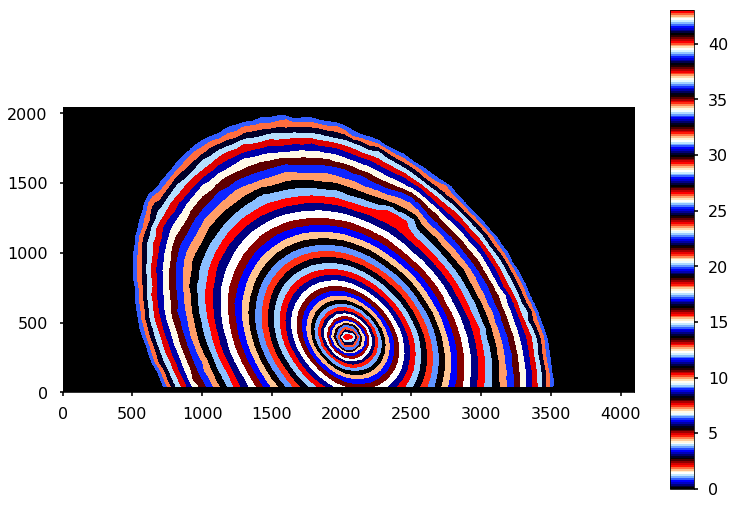

In [67]:
plt.imshow(region_map, cmap='flag_r')
plt.colorbar()

In [68]:
masks = {}
for i in range(1, region_map.max()+1):
    masks[i] = (region_map == i)

## Region Sizes

In [69]:
x_c, y_c = np.mean(np.where(region_map == region_map.max()), axis=-1)

In [70]:
sma_arcsecs = {}
minr_arcsecs = {}
npix_effs = {}
for i in range(1, region_map.max()+1):
    xs, ys = np.where(masks[i])
    npix_effs[i] = np.sqrt(len(xs)) 
    rs = np.sqrt((xs - x_c)**2 + (ys - y_c)**2)
    sma_arcsecs[i] = np.max(rs) * 0.05
    minr_arcsecs[i] = np.min(rs) * 0.05

In [71]:
d_kpc = 17000

In [72]:
sma_kpc = {i: d_kpc * sma_arcsecs[i] * (np.pi / (180 * 3600.)) for i in sma_arcsecs.keys()}
minr_kpc = {i: d_kpc * minr_arcsecs[i] * (np.pi / (180 * 3600.)) for i in minr_arcsecs.keys()}


Text(0,0.5,'Effective Npix')

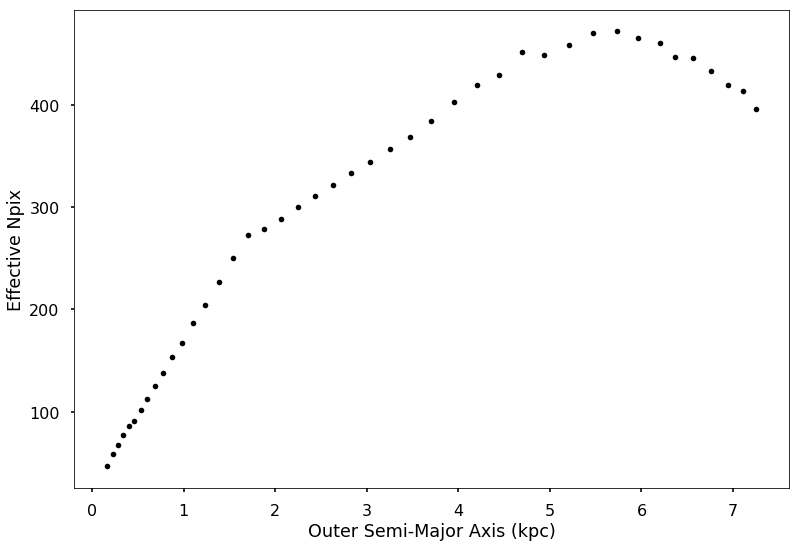

In [73]:
plt.plot(list(sma_kpc.values()), list(npix_effs.values()), 'k.')
plt.xlabel('Outer Semi-Major Axis (kpc)')
plt.ylabel('Effective Npix')

# Extract PCMDs

In [21]:
data_f475w = fits.open('../data/m49/reduced/m49_chip1_exp1_f475w_reduced.fits')['SCI'].data
data_f850lp = fits.open('../data/m49/reduced/m49_chip1_exp1_f850lp_reduced.fits')['SCI'].data

In [22]:
f475w = ppy.instrument.ACS_WFC_F475W(exposure=375.)
f850lp = ppy.instrument.ACS_WFC_F850LP(exposure=560.)

In [23]:
mags_f475w = f475w.counts_to_mag(data_f475w)
mags_f850lp = f850lp.counts_to_mag(data_f850lp)

/Users/bcook/.local/lib/python3.6/site-packages/pcmdpy/gpu_utils.py:209: RuntimeWarning: invalid value encountered in log10
  return np.log10(array_in)


In [56]:
iso_model = ppy.isochrones.Isochrone_Model([f850lp, f475w])

starting manual interpolation
done with interpolation


In [24]:
def get_pcmd(mask):
    mag = mags_f850lp[mask].flatten()
    col = (mags_f475w - mags_f850lp)[mask].flatten()
    to_use = (~np.isnan(mag))&(~np.isnan(col))
    return np.array([mag[to_use], col[to_use]])

100%|██████████| 42/42 [00:02<00:00, 16.96it/s]


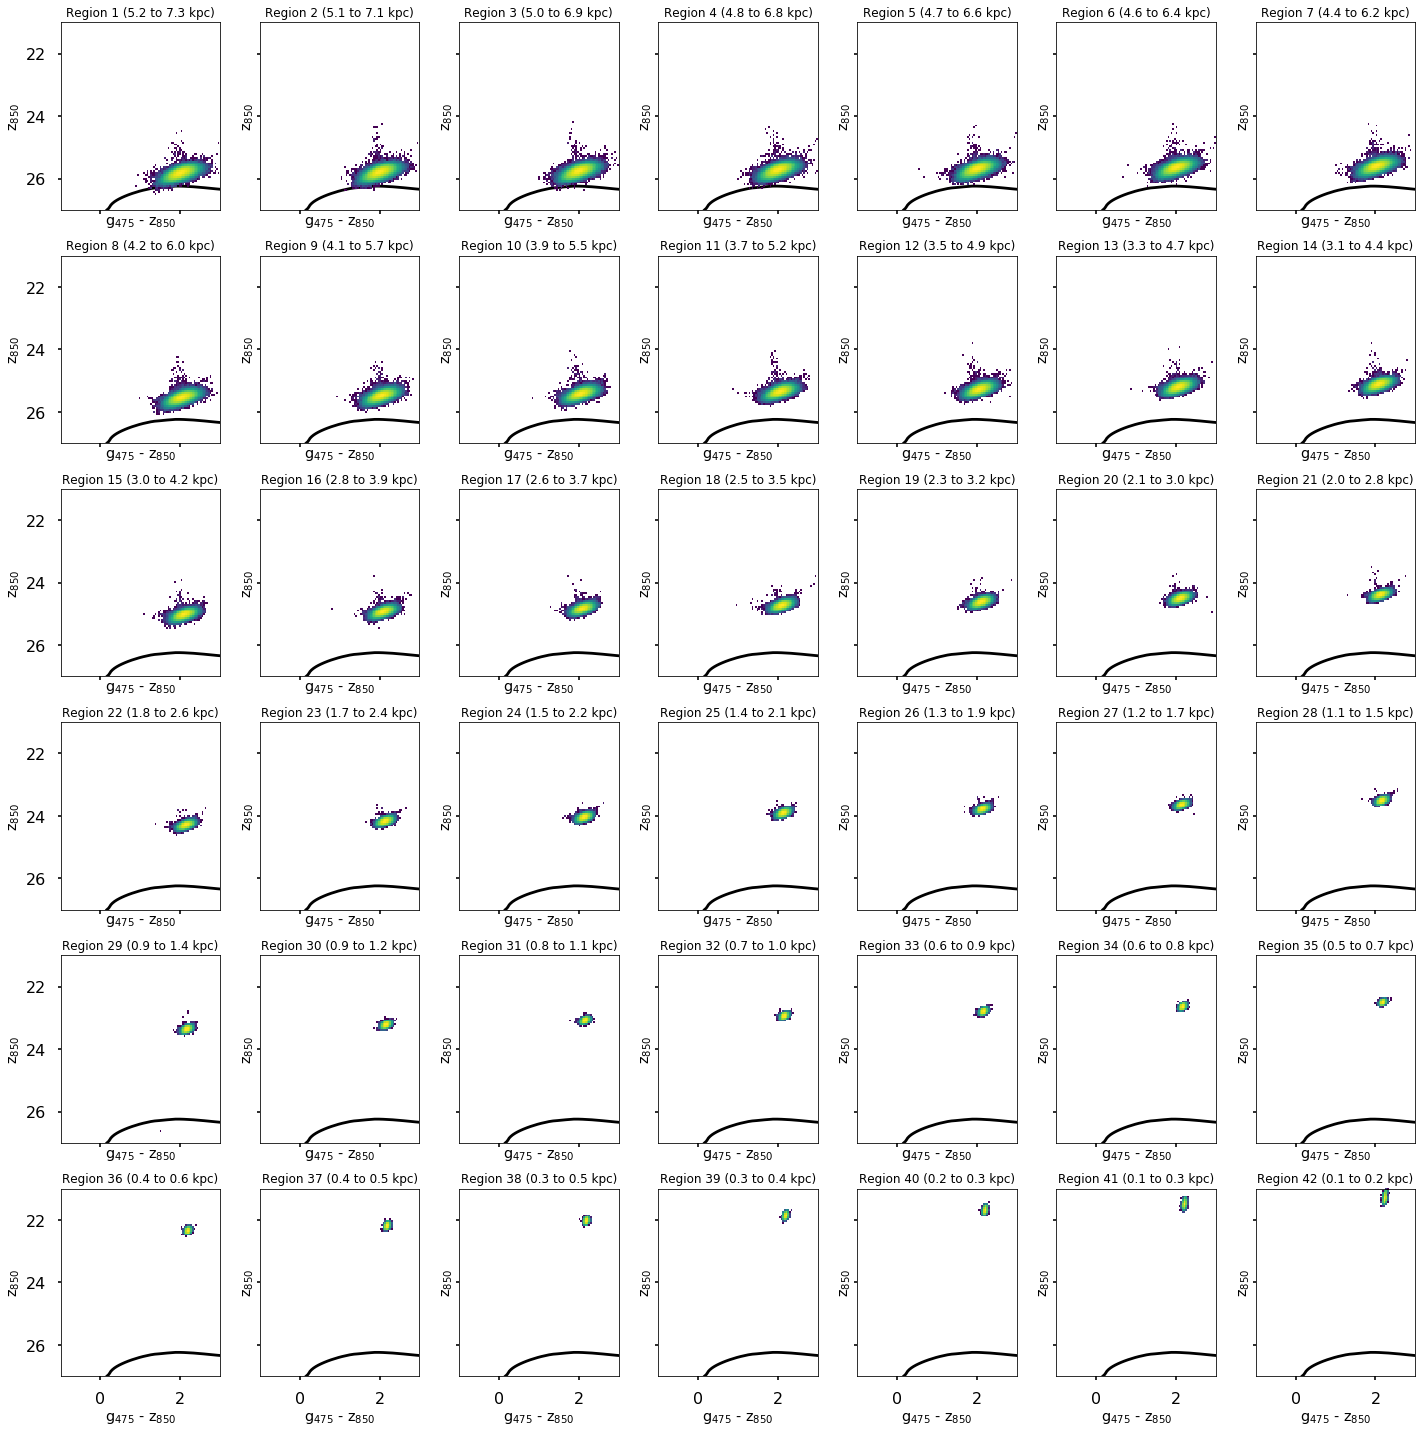

In [75]:
fig, axes = plt.subplots(figsize=(20, 20), ncols=7, nrows=6, sharex=True, sharey=True)
axes = axes.flatten()
bins = [np.linspace(-1, 3, 100), np.linspace(21, 27, 100)]
for i in tqdm(range(42)):
    ax = axes[i]
    pcmd = get_pcmd(masks[i+1])
    ax.hist2d(pcmd[1], pcmd[0], bins=bins, norm=mpl.colors.LogNorm())
    ppy.plotting.plot_isochrone(iso_model, dmod=31.29, zorder=-1, axes=ax)
    ax.set_title('Region {:d} ({:.1f} to {:.1f} kpc)'.format(i+1, minr_kpc[i+1], sma_kpc[i+1]), fontsize=12)
plt.tight_layout()

In [76]:
def save_pcmd(idx):
    mask = masks[idx]
    pcmd = get_pcmd(mask).T
    header = 'Vega Mags\n# M49 region {:d}\n'.format(idx)
    header += 'Kpc from center: {:.1f} to {:.1f}\n'.format(minr_kpc[idx], sma_kpc[idx])
    header += 'Num Pixels: {:.0f}\n'.format(npix_effs[idx]**2)
    header += 'Effective Npix: {:.1f} \n'.format(npix_effs[idx])
    header += 'zmag gmag-zmag\n'
    header += 'F850LP F475W-F850LP'
    np.savetxt('../data/m49/pcmds/m49_r{:d}_z-gz.pcmd'.format(idx), pcmd, fmt='%.6f', delimiter=' ', header=header)

In [77]:
for i in tqdm(masks.keys()):
    save_pcmd(i)

# Sky Background

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
plt.imshow(masked_images['f475w_11'], norm=mpl.colors.LogNorm(), vmax=5000)
plt.colorbar()

In [43]:
f850lp[0].header['EXPTIME']

560.0

In [45]:
sky_per_sec = np.array([34.248, 24.703]) / 400.
sky_per_sec

array([0.08562  , 0.0617575])

In [47]:
sky_total = sky_per_sec * np.array([375., 560.])
sky_total

array([32.1075, 34.5842])

In [48]:
sky_std = np.sqrt(sky_total)
sky_std

array([5.66634803, 5.88083327])

In [51]:
160 / 3600. * (np.pi / 180.) * 1.7e7

13186.93212617938

In [53]:
back = get_background(f850lp)

In [55]:
back.data.min()

42.25394821166992

In [56]:
13*(375/560.)

8.705357142857142

In [57]:
import pcmdpy

GPU acceleration not available, sorry
No module named 'pycuda'


In [58]:
f1 = pcmdpy.instrument.ACS_WFC_F475W(exposure=375.)
f2 = pcmdpy.instrument.ACS_WFC_F850LP(exposure=560.)

In [60]:
f1.counts_to_mag(2.*400)

25.328453201839437

In [64]:
f2.counts_to_mag(13.*400)

21.923461708428505

In [66]:
20.714/24.703 * 34.58

28.996078209124395

In [67]:
32.11 * (27.214 / 34.25)

25.513621605839415

In [68]:
f1.counts_to_mag((34 - 25.5)*400)

23.757480876713657

In [69]:
f2.counts_to_mag((47 - 29.)*400)

21.57013882643733